# Content-based recommender system

In [1]:
import json
import os
import unicodedata
from functools import partial

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'sans-serif'
})

In [4]:
credits = pd.read_csv(os.path.join('data', 'tmdb_5000_credits.csv'), index_col='movie_id')
movies = pd.read_csv(os.path.join('data', 'tmdb_5000_movies.csv'), index_col='id')

credits = credits.drop(columns=['title'])
movies = movies.join(credits)

del credits

In [5]:
movies

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
id,,,,,,,,,,,,,,,,,,,,,
19995,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
285,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
206647,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
49026,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
49529,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9367,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",...,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,"[{""cast_id"": 1, ""character"": "

## Feature processing

In [6]:
movies.columns

Index(['budget', 'genres', 'homepage', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [7]:
movies.drop(columns=[
    'budget',
    'homepage',
    'original_title',
    'revenue',
    'status',
    'tagline',
    'vote_count',
    'crew'
], inplace=True)

### `genres`

In [8]:
movies.loc[19995, 'genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [9]:
def extract_genre_names(json_str):
    genres = map(lambda genre: genre['name'], json.loads(json_str))
    genres = map(lambda genre: genre.lower().replace(' ', '-'), genres)
    return set(genres)

In [10]:
movies['genres'] = movies['genres'].apply(extract_genre_names)

In [11]:
encoder_genres = MultiLabelBinarizer()
genres_enc = encoder_genres.fit_transform(movies['genres'])

genre_columns = list(map(lambda genre: f'is_{genre}', encoder_genres.classes_))
genres_enc = pd.DataFrame(genres_enc, columns=genre_columns, index=movies.index)

movies = movies.join(genres_enc)
movies = movies.drop(columns=['genres'])

In [12]:
movies.loc[19995, ['title'] + genre_columns]

title                 Avatar
is_action                  1
is_adventure               1
is_animation               0
is_comedy                  0
is_crime                   0
is_documentary             0
is_drama                   0
is_family                  0
is_fantasy                 1
is_foreign                 0
is_history                 0
is_horror                  0
is_music                   0
is_mystery                 0
is_romance                 0
is_science-fiction         1
is_thriller                0
is_tv-movie                0
is_war                     0
is_western                 0
Name: 19995, dtype: object

In [13]:
movies.loc[857, ['title'] + genre_columns]

title                 Saving Private Ryan
is_action                               0
is_adventure                            0
is_animation                            0
is_comedy                               0
is_crime                                0
is_documentary                          0
is_drama                                1
is_family                               0
is_fantasy                              0
is_foreign                              0
is_history                              1
is_horror                               0
is_music                                0
is_mystery                              0
is_romance                              0
is_science-fiction                      0
is_thriller                             0
is_tv-movie                             0
is_war                                  1
is_western                              0
Name: 857, dtype: object

### `overview` and `keywords`

In [14]:
movies['overview']

id
19995     In the 22nd century, a paraplegic Marine is di...
285       Captain Barbossa, long believed to be dead, ha...
206647    A cryptic message from Bond’s past sends him o...
49026     Following the death of District Attorney Harve...
49529     John Carter is a war-weary, former military ca...
                                ...                        
9367      El Mariachi just wants to play his guitar and ...
72766     A newlywed couple's honeymoon is upended by th...
231617    "Signed, Sealed, Delivered" introduces a dedic...
126186    When ambitious New York attorney Sam is sent t...
25975     Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

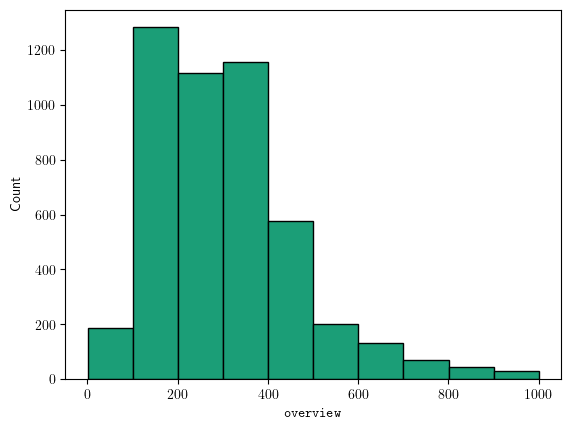

In [15]:
plt.hist(movies['overview'].str.len(), color='#1b9e77', edgecolor='k')
plt.xlabel(r'\texttt{overview}')
plt.ylabel(r'Count');

In [16]:
movies['overview'].isna().sum()

3

In [17]:
movies['overview'].fillna('', inplace=True)

In [18]:
def tokenize(raw_str):
    try:
        tokens = word_tokenize(raw_str)
    except LookupError:
        import nltk
        nltk.download('punkt')
    tokens = filter(lambda token: token.isalpha(), tokens)
    tokens = map(lambda token: token.lower(), tokens)
    tokens = map(partial(unicodedata.normalize, 'NFKC'), tokens)
    return list(tokens)

In [19]:
def to_wordnet_pos(penn_pos):
    if penn_pos.startswith('V'):
        return wordnet.VERB
    elif penn_pos.startswith('J'):
        return wordnet.ADJ
    elif penn_pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [20]:
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()

    try:
        poss = list(map(lambda tag: to_wordnet_pos(tag[1]), pos_tag(tokens)))
    except LookupError:
        import nltk
        nltk.download('averaged_perceptron_tagger')

    tokens = [
        lemmatizer.lemmatize(token, pos=poss[i])
        for i, token in enumerate(tokens)
    ]

    return tokens

In [21]:
lemmatize(['was', 'were', 'being'])

['be', 'be', 'be']

In [22]:
lemmatize(['did', 'does', 'done'])

['do', 'do', 'do']

In [23]:
def normalize(raw_str):
    tokens = tokenize(raw_str)
    tokens = lemmatize(tokens)
    return tokens

In [24]:
movies.loc[19995, 'overview']

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [25]:
' '.join(normalize(movies.loc[19995, 'overview']))

'in the century a paraplegic marine be dispatch to the moon pandora on a unique mission but become torn between follow order and protect an alien civilization'

In [26]:
movies['overview'] = movies['overview'] + movies['keywords']
movies.drop(columns=['keywords'], inplace=True)

In [27]:
movies['overview'].apply(normalize)

id
19995     [in, the, century, a, paraplegic, marine, be, ...
285       [captain, barbossa, long, believe, to, be, dea...
206647    [a, cryptic, message, from, bond, s, past, sen...
49026     [follow, the, death, of, district, attorney, h...
49529     [john, carter, be, a, former, military, captai...
                                ...                        
9367      [el, mariachi, just, want, to, play, his, guit...
72766     [a, newlywed, couple, honeymoon, be, upend, by...
231617    [sign, seal, deliver, introduces, a, dedicated...
126186    [when, ambitious, new, york, attorney, sam, be...
25975     [ever, since, the, second, grade, when, he, fi...
Name: overview, Length: 4803, dtype: object

In [28]:
try:
    stopwords.words('english')
except LookupError:
    import nltk
    nltk.download('stopwords')
stopwords_list = ENGLISH_STOP_WORDS.union(stopwords.words('english'))

In [29]:
encoder_overview = TfidfVectorizer(
    strip_accents=False,
    lowercase=False,
    preprocessor=None,
    tokenizer=None,
    analyzer=normalize,
    stop_words=stopwords_list,
    norm='l2',
    max_features=None
)
overview_enc = encoder_overview.fit_transform(movies['overview'])

overview_columns = list(map(lambda token: f'tfidf_{token}', encoder_overview.get_feature_names_out()))
overview_enc = pd.DataFrame(overview_enc.todense(), columns=overview_columns, index=movies.index)

movies = movies.join(overview_enc)
movies = movies.drop(columns=['overview'])

In [30]:
overview_columns

['tfidf_a',
 'tfidf_aa',
 'tfidf_aaa',
 'tfidf_aames',
 'tfidf_aang',
 'tfidf_aaron',
 'tfidf_aba',
 'tfidf_abaddon',
 'tfidf_abagnale',
 'tfidf_abandon',
 'tfidf_abandoned',
 'tfidf_abandonment',
 'tfidf_abba',
 'tfidf_abbas',
 'tfidf_abbate',
 'tfidf_abberline',
 'tfidf_abbey',
 'tfidf_abbie',
 'tfidf_abbott',
 'tfidf_abby',
 'tfidf_abdicate',
 'tfidf_abdication',
 'tfidf_abduct',
 'tfidf_abducted',
 'tfidf_abduction',
 'tfidf_abductor',
 'tfidf_abducts',
 'tfidf_abe',
 'tfidf_abel',
 'tfidf_aberdeen',
 'tfidf_abernathy',
 'tfidf_abhor',
 'tfidf_abhorrent',
 'tfidf_abide',
 'tfidf_abigail',
 'tfidf_ability',
 'tfidf_ablai',
 'tfidf_able',
 'tfidf_ableman',
 'tfidf_aboard',
 'tfidf_abode',
 'tfidf_abolish',
 'tfidf_abolition',
 'tfidf_abolitionist',
 'tfidf_aboriginal',
 'tfidf_aborigine',
 'tfidf_abortion',
 'tfidf_abortionist',
 'tfidf_abound',
 'tfidf_about',
 'tfidf_above',
 'tfidf_abraham',
 'tfidf_abrams',
 'tfidf_abrasive',
 'tfidf_abroad',
 'tfidf_abrupt',
 'tfidf_abruptly',
 

In [31]:
print(encoder_overview.vocabulary_)
len(encoder_overview.vocabulary_)

{'in': 8277, 'the': 16771, 'century': 2699, 'a': 0, 'paraplegic': 12310, 'marine': 10370, 'be': 1384, 'dispatch': 4712, 'to': 16951, 'moon': 11092, 'pandora': 12267, 'on': 11923, 'unique': 17600, 'mission': 10949, 'but': 2290, 'become': 1434, 'torn': 17028, 'between': 1595, 'follow': 6368, 'order': 12001, 'and': 561, 'protect': 13260, 'an': 536, 'alien': 401, 'civilization': 2991, 'id': 8105, 'name': 11378, 'culture': 3929, 'clash': 3018, 'future': 6660, 'space': 15671, 'war': 18208, 'colony': 3230, 'society': 15551, 'travel': 17177, 'futuristic': 6661, 'romance': 14326, 'tribe': 17219, 'planet': 12774, 'cgi': 2715, 'soldier': 15575, 'battle': 1363, 'love': 10000, 'affair': 246, 'anti': 649, 'power': 12999, 'relation': 13870, 'mind': 10869, 'soul': 15647, 'captain': 2479, 'barbossa': 1280, 'long': 9941, 'believe': 1489, 'dead': 4137, 'have': 7494, 'come': 3262, 'back': 1146, 'life': 9764, 'head': 7525, 'edge': 5202, 'of': 11854, 'earth': 5153, 'with': 18528, 'will': 18454, 'turner': 17

18838

### `popularity` and `vote_average`

In [32]:
movies['popularity'].describe()

count    4803.000000
mean       21.492301
std        31.816650
min         0.000000
25%         4.668070
50%        12.921594
75%        28.313505
max       875.581305
Name: popularity, dtype: float64

Not sure if we should include this? Just because two movies have a similar
popularity doesn't mean they might be similar in content. (However, a movie with
a high `popularity` or `vote_average` might be a good recommendation *by pure
chance*, in the sense that it an average user is likelier to enjoy it.)

In [33]:
movies.drop(columns=['popularity', 'vote_average'], inplace=True)

### Potentially useful features with cardinality issues

* `production_companies` / `production_countries`
* `original_language` / `spoken_languages`
* `cast`
* `runtime`: English vs Hindi (weak determinant?)
* `release_date`: Variance within an era vs across eras (very weak determinant?)

In [34]:
movies.drop(columns=[
    'production_companies',
    'production_countries',
    'original_language',
    'spoken_languages',
    'cast',
    'runtime',
    'release_date'
], inplace=True)

In [35]:
movies.columns

Index(['title', 'is_action', 'is_adventure', 'is_animation', 'is_comedy',
       'is_crime', 'is_documentary', 'is_drama', 'is_family', 'is_fantasy',
       ...
       'tfidf_zuckerberg', 'tfidf_zula', 'tfidf_zurich', 'tfidf_zuzu',
       'tfidf_zyklon', 'tfidf_à', 'tfidf_æon', 'tfidf_éloigne', 'tfidf_émigré',
       'tfidf_única'],
      dtype='object', length=18859)

## Similarity

In [36]:
titles = movies['title']
movies.drop(columns=['title'], inplace=True)

In [37]:
similarity = cosine_similarity(movies)
similarity = pd.DataFrame(similarity, index=movies.index, columns=movies.index)

In [38]:
%env TMDB_API_KEY = 9c83e29da1afbbf45faf14e915833c5c

env: TMDB_API_KEY=9c83e29da1afbbf45faf14e915833c5c


In [39]:
def topn_similar(similarity, id, n=10):
    return list(similarity[id].sort_values(ascending=False).index[1:(n+1)])

In [40]:
def pprint_topn_similar(similarity, id, titles, n=10):
    print(f'Top {n} similar movies to \"{titles[id]}\":')
    for similar_id in topn_similar(similarity, id, n=n):
        print(f'* {titles[similar_id]}')

In [41]:
pprint_topn_similar(similarity, 425, titles, n=10)

Top 10 similar movies to "Ice Age":
* Ice Age: The Meltdown
* Ice Age: Dawn of the Dinosaurs
* Ice Age: Continental Drift
* Kung Fu Panda
* TMNT
* Cars
* Curious George
* Antz
* Up
* Bolt


In [42]:
!curl https://api.themoviedb.org/3/movie/425/similar\?api_key\=${TMDB_API_KEY}\&language\=en-US | jq '.results | map(.title)' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12805  100 12805    0     0   142k      0 --:--:-- --:--:-- --:--:--  142k
[
  "Una notte",
  "Nightcap",
  "Lady and the Tramp",
  "Teaching Mrs. Tingle",
  "Let's Go to Prison",
  "The Quiet",
  "Irren ist männlich",
  "Mighty Joe Young",
  "Big Buck Bunny",
  "Hanging Up",
  "The Opposite of Sex",
  "The Go-Getter",
  "The Boy in the Plastic Bubble",
  "Otto - The Disaster Movie",
  "Beauty and the Beast",
  "My Sister's Keeper",
  "When a Stranger Calls",
  "Get Rich or Die Tryin'",
  "The Breed",
  "Slip"
]


In [43]:
pprint_topn_similar(similarity, 862, titles, n=10)

Top 10 similar movies to "Toy Story":
* Toy Story 3
* Toy Story 2
* Hotel Transylvania 2
* Monsters, Inc.
* The Simpsons Movie
* Despicable Me 2
* Over the Hedge
* Free Birds
* Doug's 1st Movie
* Chicken Little


In [44]:
!curl https://api.themoviedb.org/3/movie/862/similar\?api_key\=${TMDB_API_KEY}\&language\=en-US | jq '.results | map(.title)' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12875  100 12875    0     0   292k      0 --:--:-- --:--:-- --:--:--  292k
[
  "Nightcap",
  "Lady and the Tramp",
  "Thunderbolt",
  "The Dreamlife of Angels",
  "Explorers",
  "Grandma's Boy",
  "Cursed",
  "Beauty and the Beast",
  "The Pacifier",
  "Unleashed",
  "Very Bad Things",
  "My Lucky Stars",
  "The Lion King II: Simba's Pride",
  "The Brothers Solomon",
  "Magicians",
  "Balls of Fury",
  "Dersu Uzala",
  "Cry-Baby",
  "Lolita",
  "The Hard Corps"
]


In [45]:
pprint_topn_similar(similarity, 411, titles, n=10)

Top 10 similar movies to "The Chronicles of Narnia: The Lion, the Witch and the Wardrobe":
* The Chronicles of Narnia: Prince Caspian
* The Wizard of Oz
* The Chronicles of Narnia: The Voyage of the Dawn Treader
* Harry Potter and the Chamber of Secrets
* Harry Potter and the Philosopher's Stone
* Oz: The Great and Powerful
* The Spiderwick Chronicles
* Harry Potter and the Half-Blood Prince
* The Indian in the Cupboard
* Harry Potter and the Prisoner of Azkaban


In [46]:
!curl https://api.themoviedb.org/3/movie/411/similar\?api_key\=${TMDB_API_KEY}\&language\=en-US | jq '.results | map(.title)' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11747  100 11747    0     0   229k      0 --:--:-- --:--:-- --:--:--  229k
[
  "Fantastic Mr. Fox",
  "The Ring Two",
  "Being There",
  "Clash of the Titans",
  "Congo",
  "Freaky Friday",
  "Bugsy",
  "Moby Dick",
  "The Dark Half",
  "Seven Dwarfs",
  "Zack and Miri Make a Porno",
  "Marvin's Room",
  "Phantoms",
  "Hanging Up",
  "Happy Feet",
  "Bless the Child",
  "The Go-Getter",
  "Patriot Games",
  "Ginger Snaps",
  "Cobra"
]


In [47]:
pprint_topn_similar(similarity, 857, titles, n=10)

Top 10 similar movies to "Saving Private Ryan":
* The Thin Red Line
* The Wind That Shakes the Barley
* Downfall
* Schindler's List
* Gettysburg
* Patton
* City of Life and Death
* Hotel Rwanda
* Gods and Generals
* Amigo


In [48]:
!curl https://api.themoviedb.org/3/movie/857/similar\?api_key\=${TMDB_API_KEY}\&language\=en-US | jq '.results | map(.title)' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13049  100 13049    0     0   296k      0 --:--:-- --:--:-- --:--:--  296k
[
  "Monster",
  "Casino",
  "Terminator Salvation",
  "Spider-Man 2",
  "Constantine",
  "Starship Troopers",
  "Apollo 13",
  "The Wild Bunch",
  "Wag the Dog",
  "Driving Miss Daisy",
  "The Straight Story",
  "The English Patient",
  "The Chronicles of Narnia: The Lion, the Witch and the Wardrobe",
  "The Pianist",
  "The Good, the Bad and the Ugly",
  "Maria Full of Grace",
  "Erin Brockovich",
  "The Matrix",
  "Downfall",
  "The Last Samurai"
]


In [49]:
%env TMDB_API_KEY=

env: TMDB_API_KEY=


## Next steps

* Limit vocabulary size
* Create larger dataset
* Finalize a feature set
* Switch to sparse matrix representation
* Incorporate user ratings (hybrid model)

## Concerns

* Cardinality
* Dataset size
* Performance metrics